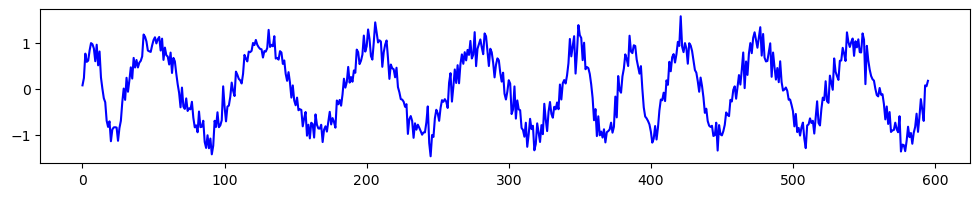

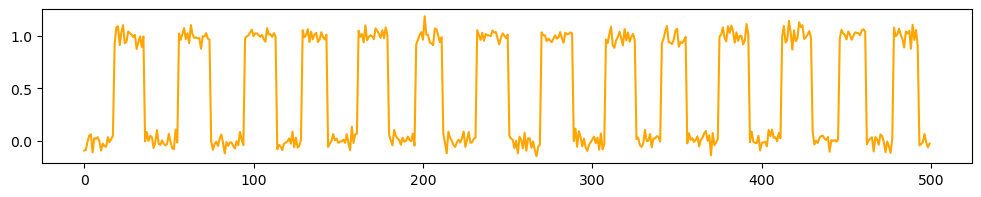

In [56]:
import matplotlib.pyplot as plt
import numpy as np

data = list()
for i in range(10):
    size = np.random.randint(30, 80)
    data += (np.sin(np.linspace(0, 2*np.pi, size)) + np.random.normal(0, 0.2, size)).tolist()
plt.figure(figsize = (12, 2))
plt.plot(data, color = "blue")
plt.show()

def generate_cyclical_series(seq_length):
    """
    生成不固定週期的 N 型波數據
    
    :param seq_length: 總數據長度
    :return: 生成的 N 型波數據 (NumPy 陣列)
    """
    data = []
    
    while len(data) < seq_length:
        period = np.random.randint(30, 40)  # 隨機週期
        half_period = period // 2

        # 生成 N 型波
        n_wave = [0] * half_period + [1] * half_period + [0] * half_period
        n_wave = n_wave[:period]  # 確保長度一致

        # 加入隨機雜訊
        n_wave = np.array(n_wave) + np.random.normal(0, 0.05, len(n_wave))

        data.extend(n_wave.tolist())

    return np.array(data[:seq_length])  # 裁剪到指定長度

data = generate_cyclical_series(500)
plt.figure(figsize = (12, 2))
plt.plot(data, color = "orange")
plt.show()

Using device: cuda
Epoch 10/500, Loss: 0.0863
Epoch 20/500, Loss: 0.0732
Epoch 30/500, Loss: 0.0638
Epoch 40/500, Loss: 0.0618
Epoch 50/500, Loss: 0.0578
Epoch 60/500, Loss: 0.0520
Epoch 70/500, Loss: 0.0500
Epoch 80/500, Loss: 0.0493
Epoch 90/500, Loss: 0.0402
Epoch 100/500, Loss: 0.0430
Epoch 110/500, Loss: 0.0379
Epoch 120/500, Loss: 0.0318
Epoch 130/500, Loss: 0.0315
Epoch 140/500, Loss: 0.0272
Epoch 150/500, Loss: 0.0240
Epoch 160/500, Loss: 0.0208
Epoch 170/500, Loss: 0.0183
Epoch 180/500, Loss: 0.0160
Epoch 190/500, Loss: 0.0146
Epoch 200/500, Loss: 0.0138
Epoch 210/500, Loss: 0.0111
Epoch 220/500, Loss: 0.0099
Epoch 230/500, Loss: 0.0124
Epoch 240/500, Loss: 0.0148
Epoch 250/500, Loss: 0.0145
Epoch 260/500, Loss: 0.0092
Epoch 270/500, Loss: 0.0088
Epoch 280/500, Loss: 0.0085
Epoch 290/500, Loss: 0.0084
Epoch 300/500, Loss: 0.0082
Epoch 310/500, Loss: 0.0108
Epoch 320/500, Loss: 0.0115
Epoch 330/500, Loss: 0.0345
Epoch 340/500, Loss: 0.0099
Epoch 350/500, Loss: 0.0081
Epoch 360/

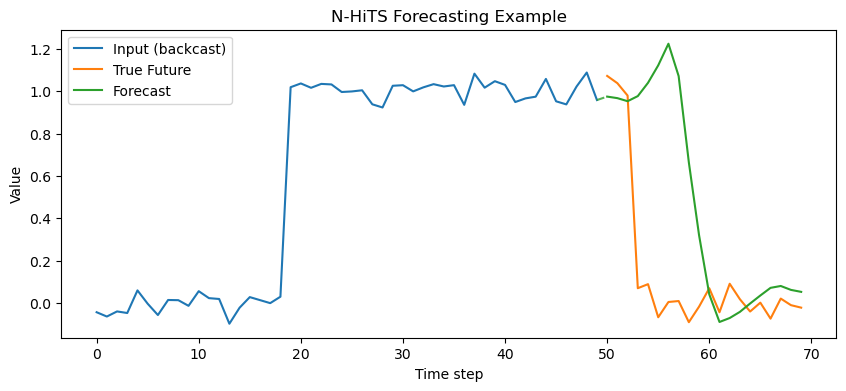

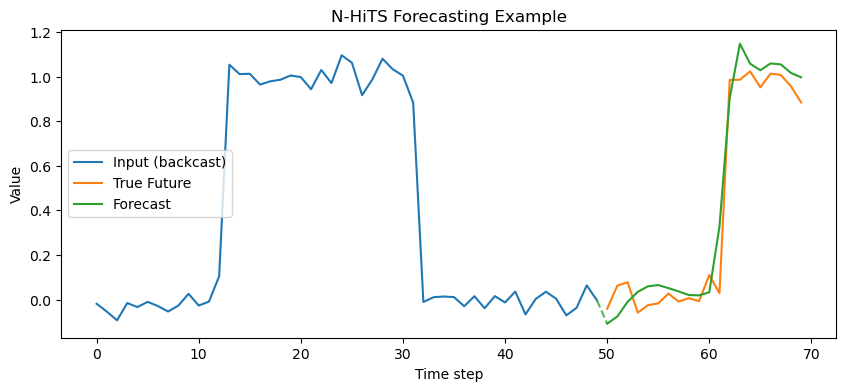

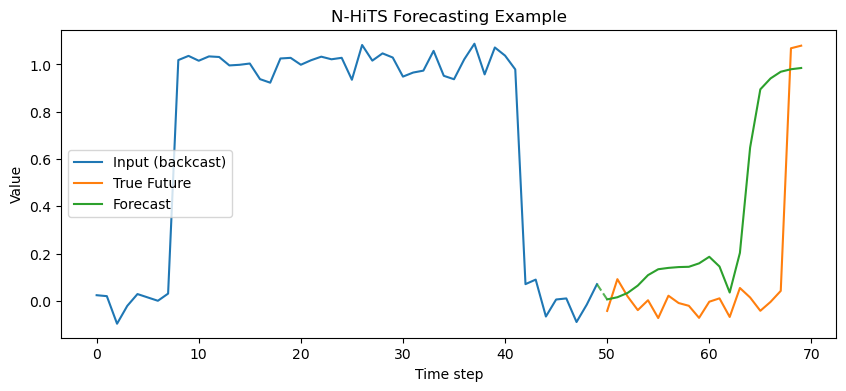

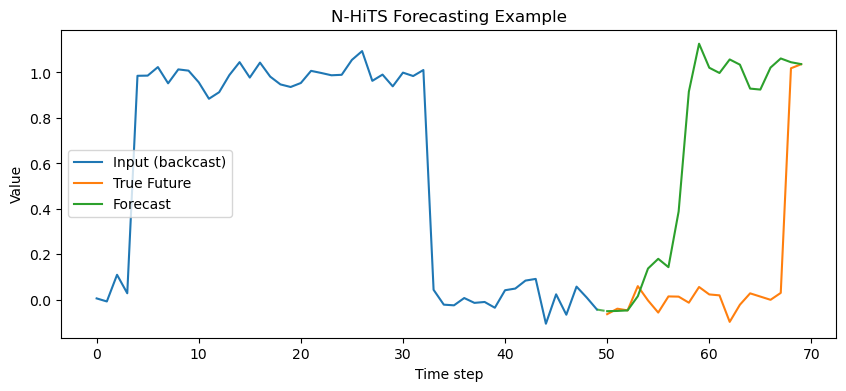

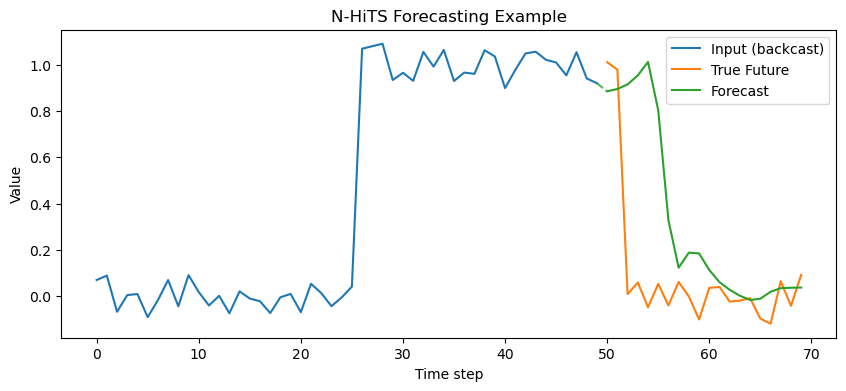

R2 score on test set: 0.5875448130038594


In [59]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 設定設備 (CUDA 訓練，CPU 推論)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# 1. 定義 N-HiTS Block 與模型
# -------------------------------

class NHiTSBlock(nn.Module):
    def __init__(self, input_size, forecast_horizon, hidden_size, n_layers, interpolation_factor=2):
        super(NHiTSBlock, self).__init__()
        self.input_size = input_size
        self.forecast_horizon = forecast_horizon
        self.interpolation_factor = interpolation_factor
        
        # 定義多層全連接層
        layers = []
        in_features = input_size
        for _ in range(n_layers):
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            in_features = hidden_size
        self.fc_layers = nn.Sequential(*layers)
        
        # 分別生成 backcast 與 forecast 的 theta
        self.theta_b = nn.Linear(hidden_size, input_size)
        low_res_len = forecast_horizon // interpolation_factor
        self.theta_f = nn.Linear(hidden_size, low_res_len)
    
    def forward(self, x):
        r = self.fc_layers(x)
        backcast = self.theta_b(r)
        low_res_forecast = self.theta_f(r)
        low_res_forecast = low_res_forecast.unsqueeze(1)  # 插值前增加維度
        forecast = F.interpolate(low_res_forecast, size=self.forecast_horizon, mode='linear', align_corners=False)
        return backcast, forecast.squeeze(1)

class NHiTS(nn.Module):
    def __init__(self, input_size, forecast_horizon, n_blocks, hidden_size, n_layers, interpolation_factor=2):
        super(NHiTS, self).__init__()
        self.blocks = nn.ModuleList([
            NHiTSBlock(input_size, forecast_horizon, hidden_size, n_layers, interpolation_factor)
            for _ in range(n_blocks)
        ])
    
    def forward(self, x):
        residual = x
        forecast = 0
        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast
        return forecast

# -------------------------------
# 2. 生成非固定週期循環序列並切 sliding windows
# -------------------------------

# def generate_cyclical_series(seq_length):
#     """
#     生成不固定週期的循環數據
#     """
#     data = []
#     for _ in range(10):
#         size = np.random.randint(30, 80)
#         data += (np.sin(np.linspace(0, 2*np.pi, size)) + np.random.normal(0, 0.2, size)).tolist()
#     return np.array(data)

def generate_cyclic_data(seq_length, period, amplitude=1.0, phase=0.0, noise=0.1):
    """
    生成週期性時間序列
    """
    data = list()
    for i in range(10):
        size = np.random.randint(30, 80)
        data += (np.sin(np.linspace(0, 2*np.pi, size)) + np.random.normal(0, 0.2, size)).tolist()
    return data

def create_sliding_windows(series, input_size, forecast_horizon):
    """
    以 sliding window 切出訓練/測試資料
    """
    X, Y = [], []
    total_length = len(series)
    for i in range(total_length - input_size - forecast_horizon + 1):
        X.append(series[i : i+input_size])
        Y.append(series[i+input_size : i+input_size+forecast_horizon])
    return np.array(X), np.array(Y)

# 參數設定
series_length = 500
input_size = 50
forecast_horizon = 20

# 生成兩組不同週期的循環序列
series1 = generate_cyclical_series(series_length)
series2 = generate_cyclical_series(series_length)

# 合併資料
combined_series = np.concatenate([series1, series2])
X1, Y1 = create_sliding_windows(series1, input_size, forecast_horizon)
X2, Y2 = create_sliding_windows(series2, input_size, forecast_horizon)
X = np.concatenate([X1, X2], axis=0)
Y = np.concatenate([Y1, Y2], axis=0)

# 切分訓練與測試
n_train = int(len(X) * 0.8)
X_train, Y_train = X[:n_train], Y[:n_train]
X_test, Y_test = X[n_train:], Y[n_train:]

# 轉成 PyTorch tensor 並移動到 GPU 訓練
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # **Inference 在 CPU 上**
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)  # **Inference 在 CPU 上**

# -------------------------------
# 3. 訓練流程 (CUDA 訓練)
# -------------------------------

# 模型參數
n_blocks = 3
hidden_size = 128
n_layers = 3
interpolation_factor = 2  

model = NHiTS(input_size=input_size, forecast_horizon=forecast_horizon, n_blocks=n_blocks,
              hidden_size=hidden_size, n_layers=n_layers, interpolation_factor=interpolation_factor).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 訓練
n_epochs = 500
batch_size = 64

model.train()
for epoch in range(n_epochs):
    permutation = torch.randperm(X_train_tensor.size(0))
    epoch_loss = 0.0
    for i in range(0, X_train_tensor.size(0), batch_size):
        optimizer.zero_grad()
        indices = permutation[i:i+batch_size]
        batch_x = X_train_tensor[indices]
        batch_y = Y_train_tensor[indices]
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= X_train_tensor.size(0)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")

# -------------------------------
# 4. 測試 (CPU 推論), 繪圖與 R2 計算
# -------------------------------

model.eval()
with torch.no_grad():
    pred_test = model(X_test_tensor.to(device)).detach().cpu().numpy()  # **Inference 在 CPU**

# 隨機選擇 5 個樣本繪製預測結果
import numpy as np
import matplotlib.pyplot as plt

# 隨機選擇 5 個樣本繪製預測結果
for sample_idx in np.random.choice(np.arange(0, X_test.shape[0]), 5):
    plt.figure(figsize=(10, 4))

    # 畫出輸入的 backcast 部分
    plt.plot(range(input_size), X_test[sample_idx], label="Input (backcast)", color="C0")
    
    # 畫出 ground truth（真實未來值）
    plt.plot(range(input_size, input_size+forecast_horizon), Y_test[sample_idx], label="True Future", color="C1")
    
    # 畫出模型的預測結果
    plt.plot(range(input_size, input_size+forecast_horizon), pred_test[sample_idx], label="Forecast", color="C2")
    
    # **補上最後一個 backcast 點到預測的第一個點的連接線**
    plt.plot(
        [input_size-1, input_size],  # X 座標從 backcast 最後一個點到預測第一個點
        [X_test[sample_idx, -1], pred_test[sample_idx, 0]],  # Y 座標
        color="C2", linestyle="dashed", alpha=0.8  # 使用虛線連接
    )
    
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.title("N-HiTS Forecasting Example")
    plt.legend()
    plt.show()


# R2 計算
r2 = r2_score(Y_test.flatten(), pred_test.flatten())
print("R2 score on test set:", r2)


Using device: cuda
Epoch 10/500, Loss: 0.0657
Epoch 20/500, Loss: 0.0558
Epoch 30/500, Loss: 0.0489
Epoch 40/500, Loss: 0.0451
Epoch 50/500, Loss: 0.0408
Epoch 60/500, Loss: 0.0368
Epoch 70/500, Loss: 0.0420
Epoch 80/500, Loss: 0.0288
Epoch 90/500, Loss: 0.0253
Epoch 100/500, Loss: 0.0255
Epoch 110/500, Loss: 0.0272
Epoch 120/500, Loss: 0.0211
Epoch 130/500, Loss: 0.0184
Epoch 140/500, Loss: 0.0199
Epoch 150/500, Loss: 0.0173
Epoch 160/500, Loss: 0.0154
Epoch 170/500, Loss: 0.0135
Epoch 180/500, Loss: 0.0142
Epoch 190/500, Loss: 0.0136
Epoch 200/500, Loss: 0.0087
Epoch 210/500, Loss: 0.0084
Epoch 220/500, Loss: 0.0072
Epoch 230/500, Loss: 0.0076
Epoch 240/500, Loss: 0.0067
Epoch 250/500, Loss: 0.0121
Epoch 260/500, Loss: 0.0056
Epoch 270/500, Loss: 0.0045
Epoch 280/500, Loss: 0.0047
Epoch 290/500, Loss: 0.0039
Epoch 300/500, Loss: 0.0032
Epoch 310/500, Loss: 0.0029
Epoch 320/500, Loss: 0.0115
Epoch 330/500, Loss: 0.0146
Epoch 340/500, Loss: 0.0059
Epoch 350/500, Loss: 0.0026
Epoch 360/

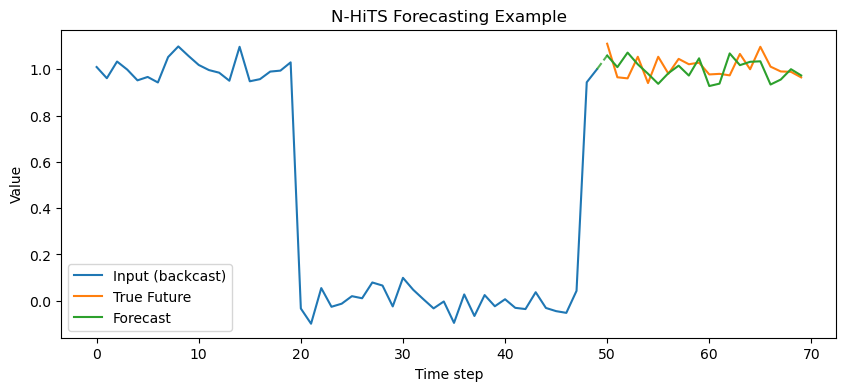

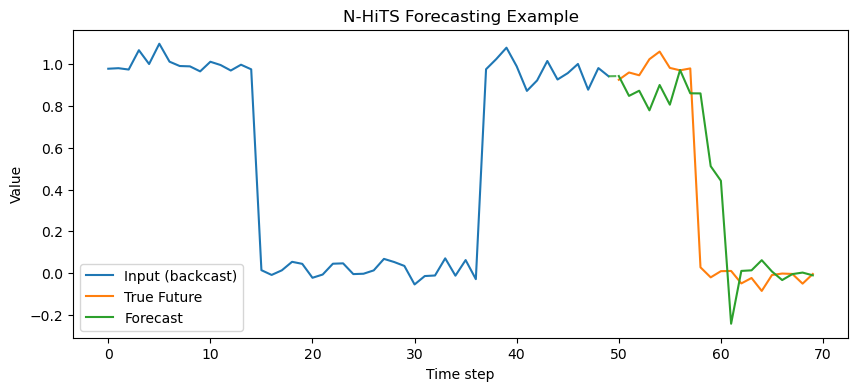

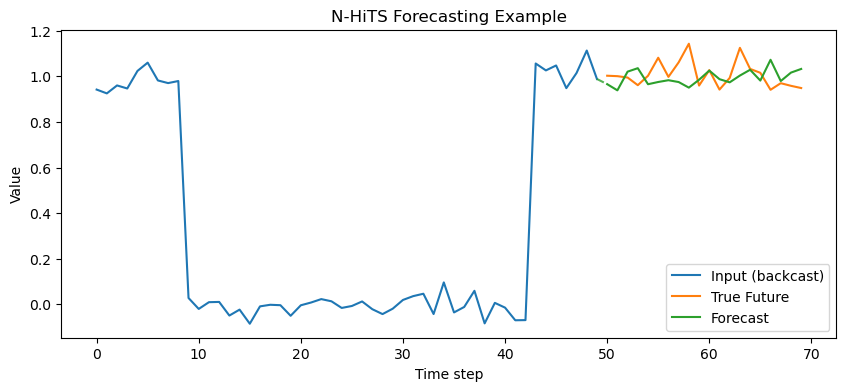

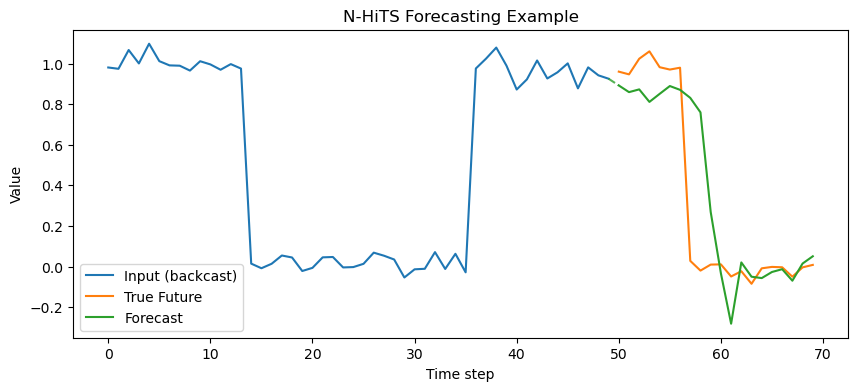

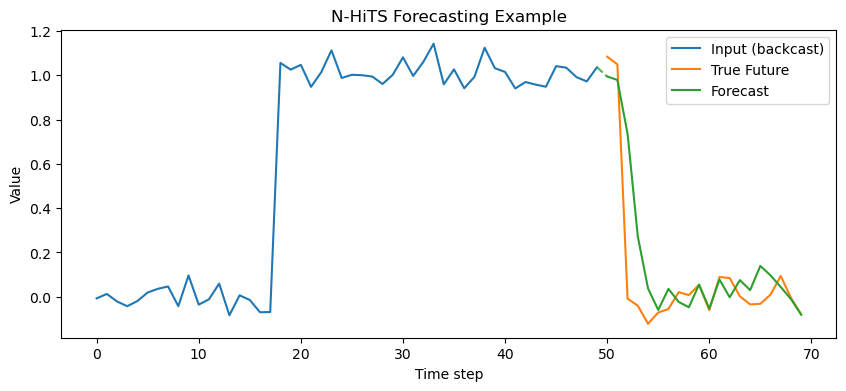

R2 score on test set: 0.5299213712770294


In [60]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 設定設備 (CUDA 訓練，CPU 推論)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# 1. 定義 N-BEATS Block 與模型
# -------------------------------

class NBeatsBlock(nn.Module):
    def __init__(self, input_size, forecast_horizon, hidden_size, n_layers):
        super(NBeatsBlock, self).__init__()
        layers = []
        in_features = input_size
        for _ in range(n_layers):
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            in_features = hidden_size
        self.fc_layers = nn.Sequential(*layers)
        
        # 兩個線性層分別產生 backcast 與 forecast
        self.backcast_linear = nn.Linear(hidden_size, input_size)
        self.forecast_linear = nn.Linear(hidden_size, forecast_horizon)
    
    def forward(self, x):
        h = self.fc_layers(x)
        backcast = self.backcast_linear(h)
        forecast = self.forecast_linear(h)
        return backcast, forecast

class NBeats(nn.Module):
    def __init__(self, input_size, forecast_horizon, n_blocks, hidden_size, n_layers):
        super(NBeats, self).__init__()
        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size, forecast_horizon, hidden_size, n_layers)
            for _ in range(n_blocks)
        ])
    
    def forward(self, x):
        residual = x
        forecast = 0
        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast
        return forecast

# -------------------------------
# 2. 生成非固定週期循環序列並切 sliding windows
# -------------------------------

# def generate_cyclical_series(seq_length):
#     """
#     生成不固定週期的循環數據
#     """
#     data = []
#     for _ in range(10):
#         size = np.random.randint(30, 80)
#         data += (np.sin(np.linspace(0, 2*np.pi, size)) + np.random.normal(0, 0.2, size)).tolist()
#     return np.array(data)

def generate_cyclical_series(seq_length):
    """
    生成不固定週期的 N 型波數據
    
    :param seq_length: 總數據長度
    :return: 生成的 N 型波數據 (NumPy 陣列)
    """
    data = []
    
    while len(data) < seq_length:
        period = np.random.randint(30, 80)  # 隨機週期
        half_period = period // 2

        # 生成 N 型波
        n_wave = [0] * half_period + [1] * half_period + [0] * half_period
        n_wave = n_wave[:period]  # 確保長度一致

        # 加入隨機雜訊
        n_wave = np.array(n_wave) + np.random.normal(0, 0.05, len(n_wave))

        data.extend(n_wave.tolist())

    return np.array(data[:seq_length])  # 裁剪到指定長度

def create_sliding_windows(series, input_size, forecast_horizon):
    """
    以 sliding window 切分序列
    """
    X, Y = [], []
    total_length = len(series)
    for i in range(total_length - input_size - forecast_horizon + 1):
        X.append(series[i : i + input_size])
        Y.append(series[i + input_size : i + input_size + forecast_horizon])
    return np.array(X), np.array(Y)

# 設定參數
series_length = 500
input_size = 50
forecast_horizon = 20

# 生成兩組不同週期的循環序列
series1 = generate_cyclical_series(series_length)
series2 = generate_cyclical_series(series_length)

# 分別切出 sliding window 資料
X1, Y1 = create_sliding_windows(series1, input_size, forecast_horizon)
X2, Y2 = create_sliding_windows(series2, input_size, forecast_horizon)

# 合併資料
X = np.concatenate([X1, X2], axis=0)
Y = np.concatenate([Y1, Y2], axis=0)

# 切分訓練與測試
n_train = int(len(X) * 0.8)
X_train, Y_train = X[:n_train], Y[:n_train]
X_test, Y_test = X[n_train:], Y[n_train:]

# 轉成 PyTorch tensor 並移動到 GPU 訓練
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # **Inference 在 CPU 上**
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)  # **Inference 在 CPU 上**

# -------------------------------
# 3. 訓練流程 (CUDA 訓練)
# -------------------------------

# 模型參數設定
n_blocks = 3
hidden_size = 128
n_layers = 4

model = NBeats(input_size=input_size, forecast_horizon=forecast_horizon,
               n_blocks=n_blocks, hidden_size=hidden_size, n_layers=n_layers).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 訓練參數
n_epochs = 500
batch_size = 64

model.train()
for epoch in range(n_epochs):
    permutation = torch.randperm(X_train_tensor.size(0))
    epoch_loss = 0.0
    for i in range(0, X_train_tensor.size(0), batch_size):
        optimizer.zero_grad()
        indices = permutation[i:i+batch_size]
        batch_x = X_train_tensor[indices]
        batch_y = Y_train_tensor[indices]
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= X_train_tensor.size(0)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")

# -------------------------------
# 4. 測試 (CPU 推論), 繪圖與 R² 計算
# -------------------------------

model.eval()
with torch.no_grad():
    pred_test = model(X_test_tensor.to(device)).detach().cpu().numpy()  # **Inference 在 CPU**

# 隨機選擇 5 個樣本繪製預測結果
for sample_idx in np.random.choice(np.arange(0, X_test.shape[0]), 5):
    plt.figure(figsize=(10, 4))

    # 畫出輸入的 backcast 部分
    plt.plot(range(input_size), X_test[sample_idx], label="Input (backcast)", color="C0")
    
    # 畫出 ground truth（真實未來值）
    plt.plot(range(input_size, input_size+forecast_horizon), Y_test[sample_idx], label="True Future", color="C1")
    
    # 畫出模型的預測結果
    plt.plot(range(input_size, input_size+forecast_horizon), pred_test[sample_idx], label="Forecast", color="C2")
    
    # **補上最後一個 backcast 點到預測的第一個點的連接線**
    plt.plot(
        [input_size-1, input_size],  # X 座標從 backcast 最後一個點到預測第一個點
        [X_test[sample_idx, -1], pred_test[sample_idx, 0]],  # Y 座標
        color="C2", linestyle="dashed", alpha=0.8  # 使用虛線連接
    )
    
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.title("N-HiTS Forecasting Example")
    plt.legend()
    plt.show()

# R² 計算
r2 = r2_score(Y_test.flatten(), pred_test.flatten())
print("R2 score on test set:", r2)
